In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D,
                                     GlobalMaxPooling2D, BatchNormalization, Concatenate )
#from tensorflow.keras.layers import GlobalMaxPooling2D
#from keras.layers.normalization import BatchNormalization
#from tensorflow.keras.layers.merge import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from tensorflow.keras import backend as K
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)

# Define a tensorflow session with above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

Metal device set to: Apple M1


2021-12-14 01:31:34.340605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-14 01:31:34.340647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Obtaining path to the image directories

In [3]:
# Define path to the data directory
data_dir = Path('/Users/noelko/2)DL/chest_xray')

# File path of training dataset
train_dir = data_dir / 'train'

# File path of validation dataset
val_dir = data_dir / 'val'

# File path of out of bag testing dataset
test_dir = data_dir / 'test'

In [4]:
# File path to the sub-directories of labelled datastes, 'normal' & 'pneumonia'
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# obtaining a list of all images,
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# then creating an empty list to append images into it
train_data = []

# 'normal' images are labelled as '0',
for img in normal_cases:
    train_data.append((img,0))

# while 'pneumonia' cases are labelled as '1'
for img in pneumonia_cases:
    train_data.append((img, 1))

# inserting the training images into a pandas dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Data shuffling, reshuffle image index for more randomization to prevent overfititng 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Let's take a look at the dataframe
train_data.head()

,image,label
0,/Users/noelko/2)DL/chest_xray/train/NORMAL/NOR...,0
1,/Users/noelko/2)DL/chest_xray/train/NORMAL/NOR...,0
2,/Users/noelko/2)DL/chest_xray/train/PNEUMONIA/...,1
3,/Users/noelko/2)DL/chest_xray/train/PNEUMONIA/...,1
4,/Users/noelko/2)DL/chest_xray/train/PNEUMONIA/...,1


## How many sample counts?

1    3875
0    1341
Name: label, dtype: int64


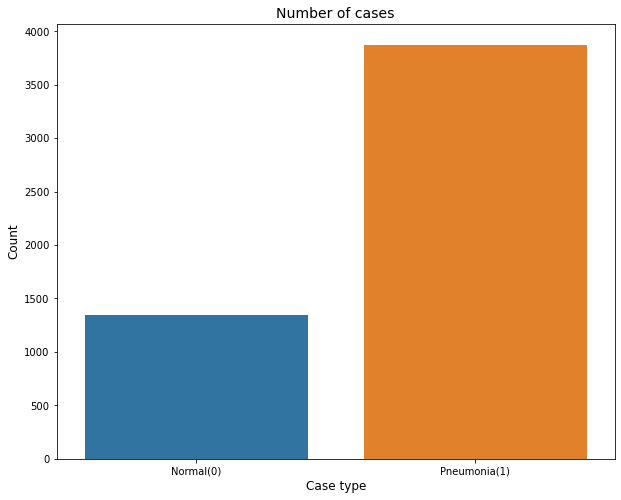

In [5]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

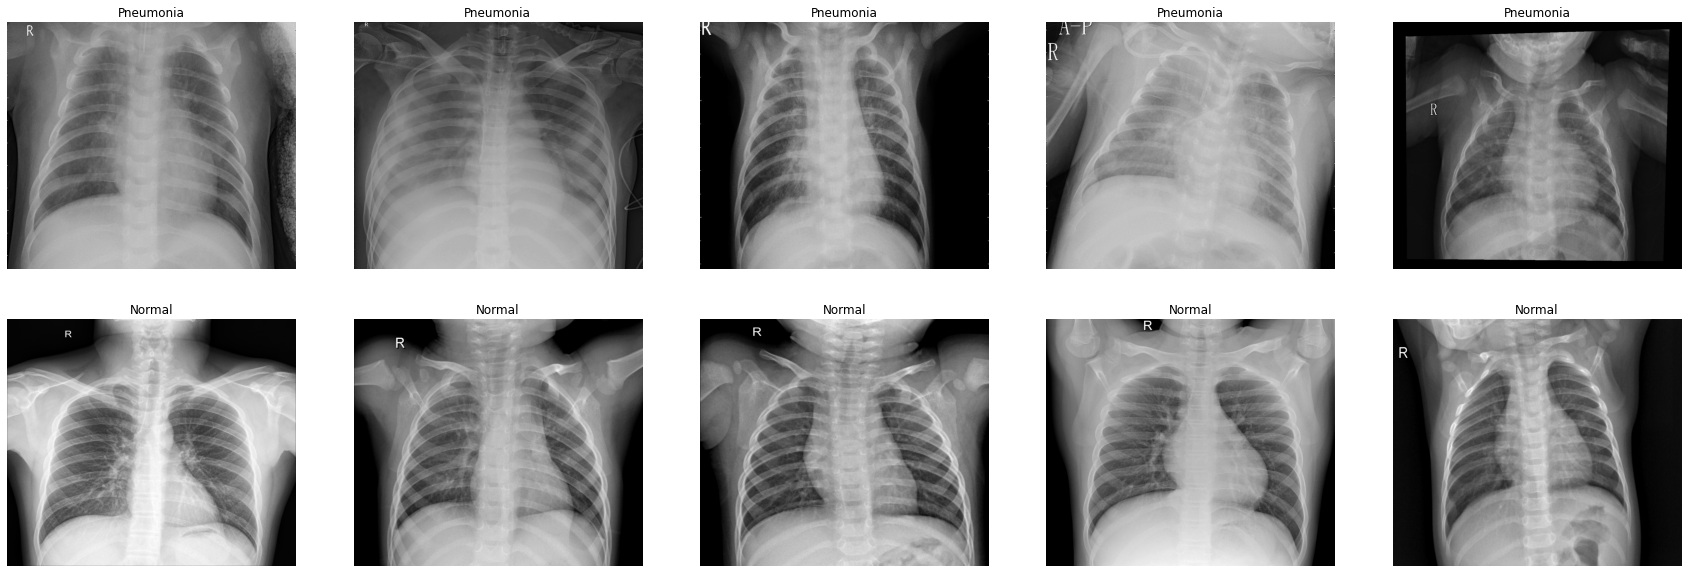

In [6]:
# GSamples for both 'pneumonia' and 'normal' cases
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concatenation of the sample list for both normal and pneumonia
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# plotting the figures to inspect our images
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Preparing validation data

In [7]:
# File path to the sub-directories of labelled datastes, 'normal' & 'pneumonia'
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# images and corresponding label lists:
valid_data = []
valid_labels = []


# Whiel majority of images are in RGB 3-channel colour, there are some images in greyscale.
# to make it consistent, we will convert all images to 3-channel RGB, 
# and then normalize the pixel values along with resizing all images to size of 224x224 square.Some images are in grayscale while majority of them contains 3 channels. So, 

# 'Normal' images
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# 'Pneumonia' images        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# both of these lists are then converted to numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


## Augmentation of data

In [8]:
# Sequence of image augmentation
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # rotation of images
    iaa.Multiply((1.2, 1.5))]) #randomized brightness

### Training set Generator

In [9]:
def data_gen(data, batch_size):
    # Total number of samples in our dataset
    n = len(data)
    steps = n//batch_size
    
    # defining 2 numpy arrays for both the image and the labe;
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # indices of input data in a numpy array
    indices = np.arange(n)
    
    # COunter and generator using a while loop
    i =0
    while True:
        np.random.shuffle(indices)
        # Getting next batch of images
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # resizing of images
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # greyscale checking
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads images in 3-channel RGB by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # pixel normalization
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generate more samples for class that was under sampled, in this case normal class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

# Modelling

In [10]:
# Using the seperable conv layers
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [11]:
#using regular layers
'''
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model
'''

"\ndef build_model():\n    input_img = Input(shape=(224,224,3), name='ImageInput')\n    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)\n    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)\n    x = MaxPooling2D((2,2), name='pool1')(x)\n    \n    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)\n    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)\n    x = MaxPooling2D((2,2), name='pool2')(x)\n    \n    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)\n    x = BatchNormalization(name='bn1')(x)\n    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)\n    x = BatchNormalization(name='bn2')(x)\n    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)\n    x = MaxPooling2D((2,2), name='pool3')(x)\n    \n    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)\n    x = Batc

In [12]:
model =  build_model()
model.summary()

2021-12-14 01:31:35.819305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-14 01:31:35.819325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [13]:
# Weight initialzation of first two convolutions with imagenets
# Open the VGG16 weight file
f = h5py.File('/Users/noelko/downloads/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [14]:
#using slower leaning rate, batch size remains at 16 and strict stopping patience of 5
opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [15]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [16]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

Epoch 1/20


/var/folders/mw/pc30gv_d00q2zp5kg2jkh2d80000gn/T/ipykernel_72478/3857689106.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
2021-12-14 01:31:36.333285: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-14 01:31:36.732991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


326/326 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.7627

2021-12-14 01:35:47.735222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


326/326 [==============================] - 255s 778ms/step - loss: 0.2270 - accuracy: 0.7627 - val_loss: 0.7554 - val_accuracy: 0.5000
Epoch 2/20
326/326 [==============================] - 248s 760ms/step - loss: 0.0693 - accuracy: 0.9548 - val_loss: 1.1935 - val_accuracy: 0.5000
Epoch 3/20
326/326 [==============================] - 251s 769ms/step - loss: 0.0480 - accuracy: 0.9664 - val_loss: 0.3309 - val_accuracy: 0.8750
Epoch 4/20
326/326 [==============================] - 248s 759ms/step - loss: 0.0425 - accuracy: 0.9747 - val_loss: 0.6644 - val_accuracy: 0.7500
Epoch 5/20
326/326 [==============================] - 247s 759ms/step - loss: 0.0443 - accuracy: 0.9714 - val_loss: 0.5173 - val_accuracy: 0.8125
Epoch 6/20
326/326 [==============================] - 251s 769ms/step - loss: 0.0344 - accuracy: 0.9785 - val_loss: 0.1241 - val_accuracy: 0.9375
Epoch 7/20
326/326 [==============================] - 248s 759ms/step - loss: 0.0352 - accuracy: 0.9751 - val_loss: 1.1637 - val_accura

In [17]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)


Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [18]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)


2021-12-14 14:06:30.111322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 11s 264ms/step - loss: 1.2934 - accuracy: 0.7580
Loss on test set:  1.2934094667434692
Accuracy on test set:  0.7580128312110901


In [19]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

2021-12-14 14:06:43.345366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(624,)
(624,)


<Figure size 432x288 with 0 Axes>

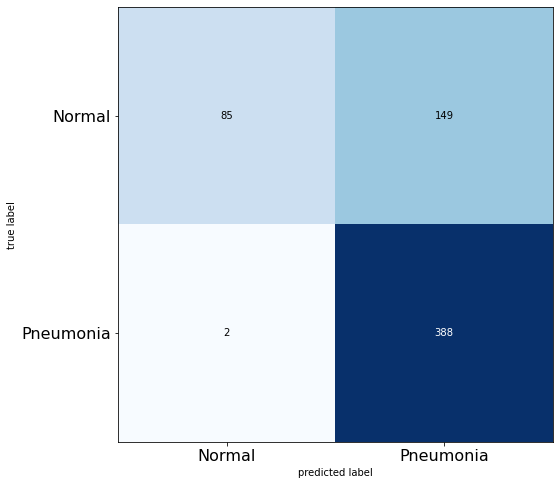

In [20]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [21]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.72


history = model.fit(
    train_data_gen,
    steps_per_epoch=nb_train_steps,
    epochs=100,
    validation_data=(valid_data, valid_labels),
    
    class_weight={0:1.0, 1:0.4},
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

'''
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})
'''

In [ ]:
'''
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
'''

In [ ]:
'''
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
'''